# Cover Image

The purpose of this notebook is to create a simple, high-resolution
background image for Notes on Truth.

## Color Scheme Source

This is helpful: https://color.adobe.com/explore

## Imports

In [245]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

In [5]:
# Learning how to work with images as data.

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

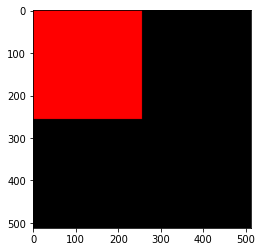

In [8]:
plt.imshow(img);

In [10]:
# Create a boring gradient.

data = np.zeros((h, w, 3), dtype=np.float16)

In [12]:
def fill(arr, color):
    arr[:, :] = np.array(color)

In [13]:
fill(data, [0, 1, 0])

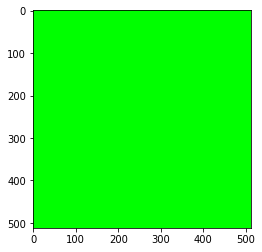

In [17]:
plt.imshow(Image.fromarray((data * 255).astype(np.uint8)));

In [18]:
def show(data):
    plt.imshow(Image.fromarray((data * 255).astype(np.uint8)))

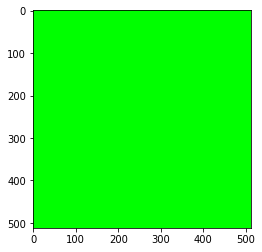

In [19]:
show(data)

In [21]:
data.shape

(512, 512, 3)

In [29]:
def make_gradient(arr, from_color, to_color):
    from_color = np.array(from_color)
    to_color   = np.array(to_color)
    h = arr.shape[0]
    for i in range(h):
        a = i / (h - 1)
        arr[i, :] = (1 - a) * from_color + a * to_color

In [30]:
make_gradient(data, [0, 1, 0], [0, 0, 1])

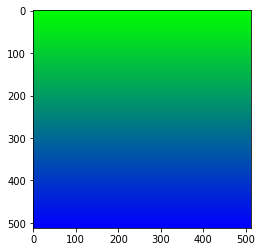

In [31]:
show(data)

In [ ]:
# Next steps
#  [x] Make a smaller image and display with a lot of zoom so I can
#      better see the gradient in detail, at scale.
#  [x] Aim for a high-contrast gradient to help me see.
#  [ ] Implement and play around with some dithering, like blue
#      noise, to make things look good.

In [36]:
w, h = 20, 20
data = np.zeros((h, w, 3), dtype=np.float16)

In [47]:
g = 0.5
make_gradient(data, [0, 0, 0], [g, g, g])

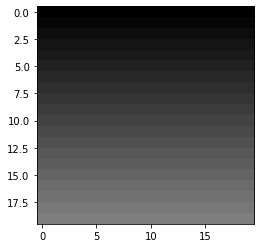

In [48]:
show(data)

Change of plan. I'm not sure that dithering is really
the issue I want to tackle right now.

I suspect what I'd like to do is more like
an advanced gradient, but with some randomness to
make it visually more interesting.

How exactly might that randomness work?

One idea is that we begin by thinking of a base image as
a function $f:(x,y)\mapsto (r, g, b)$.

Then we create a new function $g(x, y)$, and we render that.
And the function works via some mapping $h:(x,y)\mapsto (x,y)$.

What might $h(x, y)$ look like?

It should be continuous and semilocal, meaning that $||h(x,y)-(x,y)||$ is not huge.

So we might choose a noise function $n_i(x,y)$ which is continuous and gives
somewhat random values in a range $[-\epsilon, \epsilon]$.

Perler noise is a candidate.

Let's try some different variations and see how they look.

I'll think of the functions as mapping from $[0,1]^2$ to $[0,1]^3$.
(The image functions, not $h()$.)

In [49]:
def grad_fn(from_color, to_color):
    # This returns a function that maps x, y to a 01 rgb triple.
    from_color = np.array(from_color)
    to_color   = np.array(to_color)
    def img_fn(x, y):
        return y * from_color + (1 - y) * to_color
    return img_fn

In [50]:
img_fn = grad_fn([0, 0, 1], [1, 1, 0])

In [59]:
def show_img_fn(img_fn, w=50, h=50):
    data = np.zeros((h, w, 3), dtype=np.float16)
    for y in range(h):
        for x in range(w):
            data[y, x] = img_fn(x / w, y / h)
    show(data)

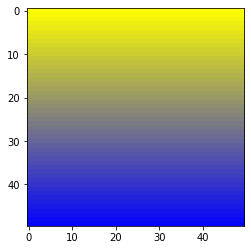

In [60]:
show_img_fn(img_fn)

In [65]:
# Generate a random grid for use in a Fourier-like fn.

r = np.random.randn(3, 3)
r

array([[ 0.16069216,  0.49771414, -1.20970575],
       [-1.58585554, -0.57012063, -0.18844611],
       [-0.19421266, -0.14134188,  0.789404  ]])

In [68]:
math.pi

3.141592653589793

In [82]:
def make_noise_fn(scale=0.02):
    """ Return a fn that maps (x, y) to a cts random value close-ish to 0. """
    w, h = 3, 3
    r = np.random.randn(w, h)
    
    # Interpret r[i, j] as the coefficient of
    # cos(2π i x) cos(2π j y).
    tau = 2 * math.pi
    
    def noise_fn(x, y):
        v = 0
        for i in range(w):
            for j in range(h):
                v += r[i, j] * math.cos(tau * i * x) * math.cos(tau * j * y)
        return scale * v
    
    return noise_fn

In [115]:
scale = 0.1

In [116]:
noise_fn1 = make_noise_fn(scale)

In [117]:
noise_fn1(0, 0.01)

0.17697487663973427

In [118]:
noise_fn2 = make_noise_fn(scale)

In [119]:
def clamp(x, lo, hi):
    if x < lo:
        return lo
    if x > hi:
        return hi
    return x

In [120]:
def img_fn2(x, y):
    x = clamp(x + noise_fn1(x, y), 0, 1)
    y = clamp(y + noise_fn2(x, y), 0, 1)
    return img_fn(x, y)

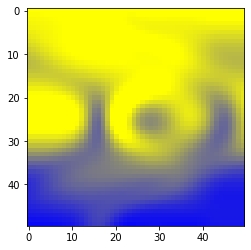

In [121]:
show_img_fn(img_fn2)

In [91]:
img_fn(0.1, 0.2)

array([0.8, 0.8, 0.2])

In [95]:
x=0.11; y=0.2; img_fn(noise_fn1(x, y), noise_fn2(x, y))

array([ 1.02394057,  1.02394057, -0.02394057])

In [146]:
def compose_w_transform(img_fn, x_fn, y_fn):
    def composed_fn(x, y):
        x = clamp(x + x_fn(x, y), 0, 1)
        y = clamp(y + y_fn(x, y), 0, 1)
        return img_fn(x, y)
    return composed_fn

In [159]:
scale   = 0.01
base_fn = grad_fn([1, 0.5, 0], [0.6, 0.3, 0.2])
x_fn    = make_noise_fn(scale)
y_fn    = make_noise_fn(scale)
img_fn  = compose_w_transform(base_fn, x_fn, y_fn)

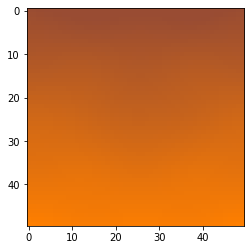

In [160]:
show_img_fn(img_fn)

In [141]:
y_fn(1, 1)

0.0

In [202]:
# Let's set up an advanced gradient image function.

def adv_grad(key_pts, colors):
    """ This accepts a list of key points in [0, 1], such as [0, 0.2, 1]; and a
        list of 01 rgb colors of equal length. It returns a function that accepts (x, y)
        and returns the appropriate color that is a linear interpolation along the y-axis
        of the given colors, each being exactly represented at the corresponding key point.
    """
    
    assert len(key_pts) == len(colors)
    assert len(key_pts) > 1
    
    if key_pts[1] < key_pts[0]:
        key_pts = list(reversed(key_pts))
        colors  = list(reversed(colors))
    
    assert key_pts[0] == 0 and key_pts[-1] == 1
    
    n = len(key_pts)
    colors = list(map(np.array, colors))
    
    def img_fn(x, y):
        # Find i so that key_pts[i] < y <= key_pts[i + 1].
        i = 0
        while i < n - 2 and key_pts[i + 1] < y:
            i += 1
        k1, k2 = key_pts[i], key_pts[i + 1]
        a = (y - k1) / (k2 - k1)
        return (1 - a) * colors[i] + a * colors[i + 1]
    
    return img_fn

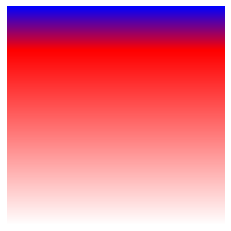

In [203]:
show_img_fn(adv_grad([0, 0.2, 1], [[0, 0, 1], [1, 0, 0], [1, 1, 1]]), w=200, h=200)

In [189]:
s = '#042940'
if s.startswith('#'):
    s = s[1:]
from_hex = lambda s: int(s, 16)
[from_hex(s[:2]), from_hex(s[2:4]), from_hex(s[4:])]

[4, 41, 64]

In [190]:
from_hex = lambda s: int(s, 16)

def rgb01_from_hex(s):
    if s.startswith('#'):
        s = s[1:]
    return np.array([from_hex(s[:2]), from_hex(s[2:4]), from_hex(s[4:])]) / 255

In [191]:
colors = [
    rgb01_from_hex('#042940'),
    rgb01_from_hex('#005C53'),
    rgb01_from_hex('#9FC131')
]

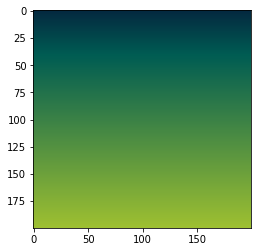

In [193]:
show_img_fn(adv_grad([0, 0.2, 1], colors), w=200, h=200)

In [194]:
colors = [
    '#042940',
    '#042940',
    '#005C53',
    '#005C53',
    '#9FC131',
    '#9FC131'
]
colors = list(map(rgb01_from_hex, colors))

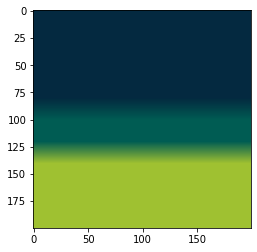

In [197]:
show_img_fn(adv_grad([0, 0.4, 0.5, 0.6, 0.7, 1], colors), w=200, h=200)

In [199]:
def show(data, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(Image.fromarray((data * 255).astype(np.uint8)))

def show_img_fn(img_fn, w=50, h=50, figsize=None):
    data = np.zeros((h, w, 3), dtype=np.float16)
    for y in range(h):
        for x in range(w):
            data[y, x] = img_fn(x / w, y / h)
    show(data, figsize)

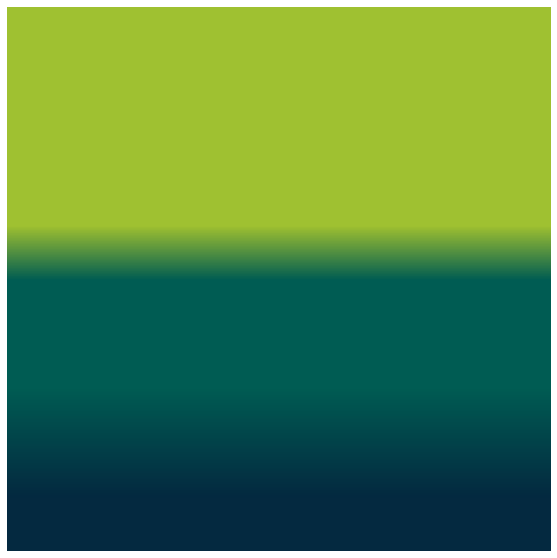

In [209]:
show_img_fn(adv_grad([1, 0.9, 0.7, 0.5, 0.4, 0], colors), w=200, h=200, figsize=(10, 10))

In [217]:
scale   = 0.005
base_fn = adv_grad([1, 0.9, 0.7, 0.5, 0.2, 0], colors)
x_fn    = make_noise_fn(scale)
y_fn    = make_noise_fn(scale)
img_fn  = compose_w_transform(base_fn, x_fn, y_fn)

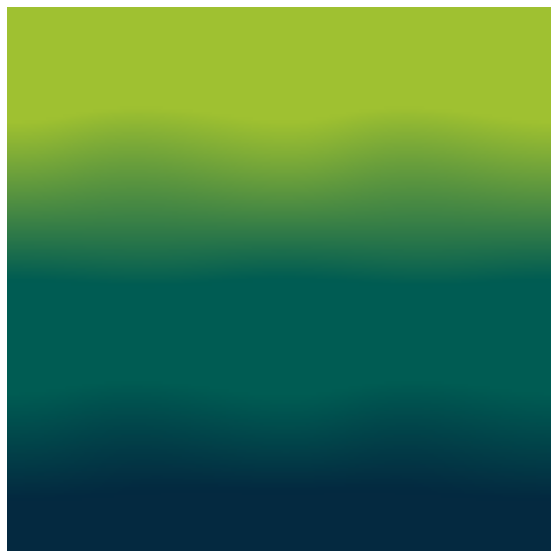

In [218]:
show_img_fn(img_fn, w=200, h=200, figsize=(10, 10))

In [219]:
def make_noise_fn(scale=0.02, k=5):
    """ Return a fn that maps (x, y) to a cts random value close-ish to 0. """
    w, h = k, k
    r = np.random.randn(w, h)
    
    # Interpret r[i, j] as the coefficient of
    # cos(2π i x) cos(2π j y).
    tau = 2 * math.pi
    
    def noise_fn(x, y):
        v = 0
        for i in range(w):
            for j in range(h):
                v += r[i, j] * math.cos(tau * i * x) * math.cos(tau * j * y)
        return scale * v
    
    return noise_fn

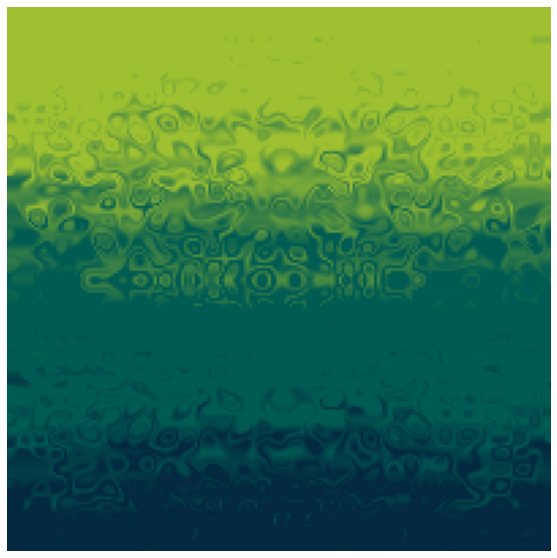

In [221]:
scale   = 0.005
base_fn = adv_grad([1, 0.9, 0.7, 0.5, 0.2, 0], colors)
x_fn    = make_noise_fn(scale, k=20)
y_fn    = make_noise_fn(scale, k=20)
img_fn  = compose_w_transform(base_fn, x_fn, y_fn)

show_img_fn(img_fn, w=200, h=200, figsize=(10, 10))

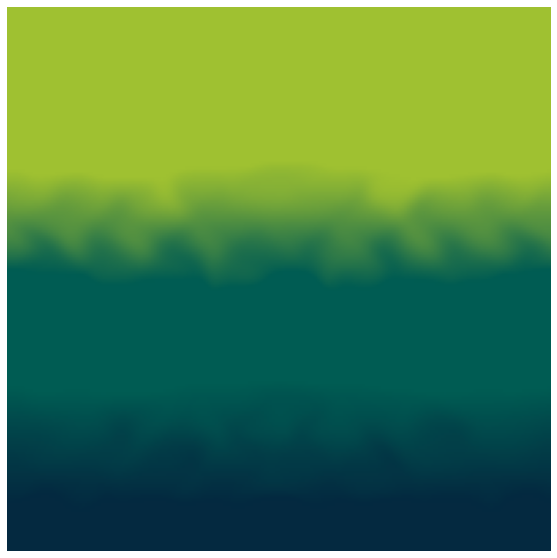

In [227]:
scale   = 0.002
base_fn = adv_grad([1, 0.9, 0.7, 0.5, 0.3, 0], colors)
x_fn    = make_noise_fn(scale, k=10)
y_fn    = make_noise_fn(scale, k=10)
img_fn  = compose_w_transform(base_fn, x_fn, y_fn)

show_img_fn(img_fn, w=200, h=200, figsize=(10, 10))

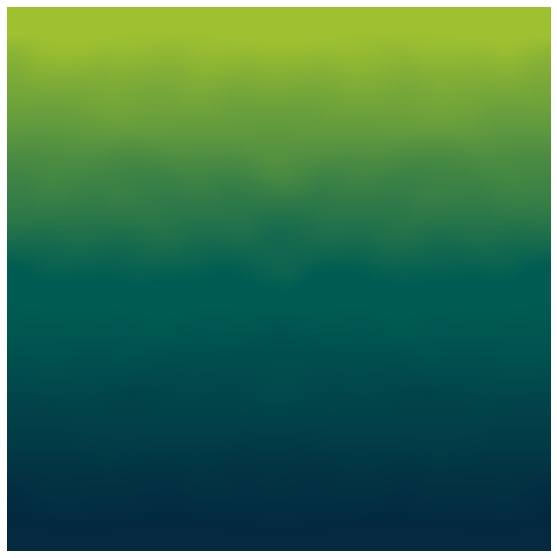

In [232]:
scale   = 0.002
base_fn = adv_grad([1, 0.95, 0.55, 0.5, 0.05, 0], colors)
x_fn    = make_noise_fn(scale, k=8)
y_fn    = make_noise_fn(scale, k=8)
img_fn  = compose_w_transform(base_fn, x_fn, y_fn)

show_img_fn(img_fn, w=200, h=200, figsize=(10, 10))

In [246]:
def get_pil_img(img_fn, w, h):
    data = np.zeros((h, w, 3), dtype=np.float16)
    for y in tqdm(range(h)):
        for x in range(w):
            data[y, x] = img_fn(x / w, y / h)
    return Image.fromarray((data * 255).astype(np.uint8))

In [235]:
img = get_pil_img(img_fn, 10, 10)
img.save('a.png')

In [236]:
!open .

In [239]:
%%time
img = get_pil_img(img_fn, 1000, 100)
img.save('a.png')

CPU times: user 10.5 s, sys: 77.8 ms, total: 10.6 s
Wall time: 10.9 s


In [240]:
# 100,000 pixels takes 10.9 s
# So how long will my full image take?

a = 3718 * 2760
a

10261680

In [242]:
10.9 * (a / 100000)

1118.52312

In [243]:
_ / 60

18.642052

In [244]:
# It will take a little over 18 minutes, it seems.

In [247]:
img = get_pil_img(img_fn, 1000, 100)
img.save('a.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


In [248]:
img = get_pil_img(img_fn, 3718, 2760)
img.save('background.png')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2760/2760 [19:19<00:00,  2.38it/s]
